## ML Pipelines with ZenML  

**Key Concepts:** *ML Pipelines, Steps*  

- In this notebook, techniques are shown on how to easily convert existing ML code into ML pipelines using ZenML.  
- Models will be built with [sklearn](https://scikit-learn.org).  
- ZenML & sklearn integration installed. Use the following command, which will also restart the kernel of your notebook:  


### Why ML Pipelines

As an ML practitioner, I am familiar with building models using scikit-learn, PyTorch, TensorFlow, or similar. An **ML pipeline** extends that work by including the steps that happen before or after training—data acquisition, preprocessing, deployment, and monitoring. The pipeline defines a step-by-step procedure for my work.

**Why I code pipelines explicitly:**
- I can rerun the entire workflow—not just the model—reducing bugs and improving reproducibility.
- Data and models are versioned and tracked, so I can quickly see which dataset a model used and how it compares to others.
- With the pipeline in code, I can automate operational tasks such as retraining and redeploying when data changes, and I can roll out improvements through CI/CD.

Having a clearly defined ML pipeline is essential when serving models at scale.

### ZenML Setup

In this series, I define ML pipelines using **ZenML**. The framework is straightforward to use and integrates with many advanced MLOps tools. I make sure ZenML is installed (e.g., `pip install zenml` or `pip install "zenml[server]"`) and then run the initial commands I need to start with a fresh ZenML stack before building the pipeline.


In [1]:
# Imports
import IPython
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

C:\Users\Coelh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
# Getting started with some simple exemplary ML. Scikit-learn SVC Classifier images of hawritten digits (training)
# Simple example

def train_test() -> None:
    # Train and test Sckit-learn SVC classifier on digits
    digits = load_digits()
    data = digits.images.reshape((len(digits.images), -1))
    X_train, X_test, y_train, y_test = train_test_split(
        data, digits.target, test_size=0.2, shuffle=False
    )
    model = SVC(gamma=0.001)
    model.fit(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"Test Accuracy: {test_acc}")

train_test()

Test Accuracy: 0.9583333333333334


## Turning experiments into ML pipelines with ZenML

In practice, ML workflows are more complex than a single training script. Preprocessing often should not be repeated for every run, model variants need side-by-side comparison, and results must be deployed and monitored. Defining an ML pipeline encodes this process as modular steps that can be mixed and matched.

```text
╭──────────────╮     ╭──────────────╮     ╭──────────────╮
│   Importer   │ ○─▶    SVC Trainer │ ○──▶     Evaluator│
╰──────────────╯     ╰──────────────╯     ╰──────────────╯


In [3]:
import numpy as np
from zenml import step
from typing_extensions import Annotated
import pandas as pd
from typing import Tuple

In [4]:
@step
def importer() -> Tuple[
    Annotated[np.ndarray, "X_train"],
    Annotated[np.ndarray, "X_test"],
    Annotated[np.ndarray, "y_train"],
    Annotated[np.ndarray, "y_test"],
]:
    # Load the digits dataset as numpy array
    digits = load_digits()
    data = digits.images.reshape((len(digits.images), -1))
    X_train, X_test, y_train, y_test = train_test_split(
        data, digits.target, test_size=0.2, shuffle=False
    )
    return X_train, X_test, y_train, y_test

@step
def svc_trainer(
    X_train: np.ndarray,
    y_train: np.ndarray,
) -> ClassifierMixin:
    # Train an sklearn SVC Classifier
    model = SVC(gamma=0.001)
    model.fit(X_train, y_train)
    return model

@step
def evaluator(
    X_test: np.ndarray,
    y_test: np.ndarray,
    model: ClassifierMixin,
) -> float:
    # Calculate the test set accuracy of an sklearn model
    test_acc = model.score(X_test, y_test)
    print(f"Test Accuracy: {test_acc}")
    return test_acc

Similarly, I can use ZenML’s `@pipeline` decorator to connect all steps into an ML pipeline.

*Note:* The pipeline definition does not depend on the concrete step functions defined above; it simply establishes a recipe for how data flows through the steps. Steps can be swapped as needed—for example, running the same pipeline with different models to compare performance.


In [5]:
from zenml import pipeline

@pipeline
def digits_pipeline():
    # Links all the steps together in a pipeline
    X_train, X_test, y_train, y_test = importer()

    model = svc_trainer(X_train=X_train, y_train=y_train)
    evaluator(X_test=X_test, y_test=y_test, model=model)

## Running ZenML Pipeline

Initialize the pipeline with concrete step functions and call the `run()` method

In [8]:
#digits_svc_pipeline = digits_pipeline()
# digits_svc_pipeline.run(unlisted=True)

In [9]:
# from zenml.environment import Environment

# def start_zenml_dashboard(port=8237):
#     if Environment.in_google_colab():
#         from pyngrok import ngrok
#         public_url = ngrok.connect(port)
#         # Colored note for Colab users (ANSI escape codes)
#         print(f"\x1b[1;33mIn Colab, use this URL instead: {public_url}!\x1b[0m")
#         !zenml up --blocking --port {port}
#     else:
#         !zenml up --port {port}

# start_zenml_dashboard()

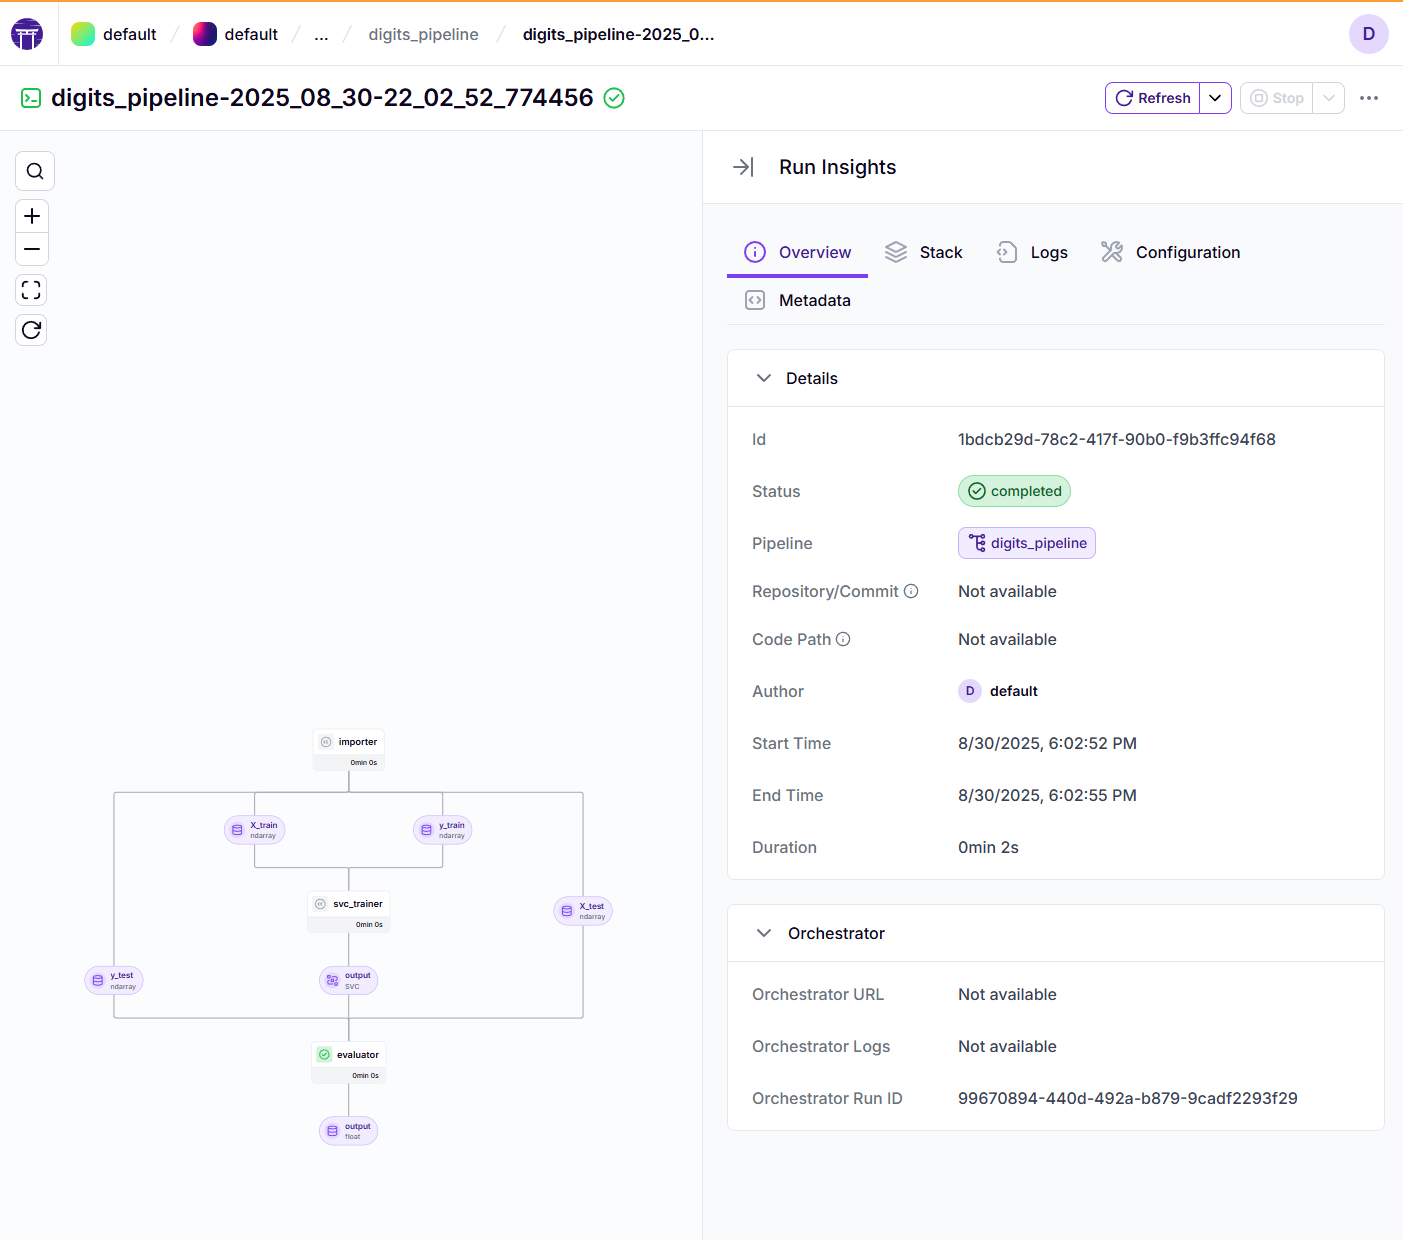

In [ ]:
from IPython.display import Image, display

# Basic visualization of the pipeline
display(Image(filename="pipeline_created.png"))
